### 도시가스 고객센터 상담이력정보 분석 - 3. 현업 요청사항 F/up  
- Source Data : 이지원 상담이력정보 테이별(APDB_CL_CS_COUNSEL_CALL_HISTORY_TM) 
- DB info. : DataPlatform RDS(MSSQL)
- Raw Data size : 13,558,241건 (2019.12.02~2023.07.21, 약 8.3GB) 
- 분석대상 Data size : 3,345,622건 (2022.01.01~2022.12.31, 압축후 약 446MB)
- columns 정보 : http://localhost:8888/doc/tree/work_2023/07.%EA%B5%90%EC%9C%A1_%EC%9D%B8%EC%9E%85%EC%BD%9C%ED%9A%A8%EC%9C%A8%ED%99%94/columns_detail.png
---

In [1]:
## 필수 pkg's 및 한글폰트 사용 설정 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')
import time 

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rc('axes',unicode_minus=False)

In [2]:
## Dataset loading 
start = time.time()  

df_2022 = pd.read_parquet('data/df_2022.parquet')
print(df_2022.shape)
pd.set_option('display.max_columns', None)
df_2022.head(2)

print("time :", time.time() - start)

(3345622, 64)
time : 25.894772052764893


---
### 요청 1. 부동산/관리실 등으로 부터 인입콜 중, 콜 감축활동 targetting을 위한 top N 인입처 파악 
---

In [3]:
## 부동산/관리실 등으로 부터의 인입건 추출 

## 31개 키워드 선정 
key_words = '집주인|주인|소유주|주인세대|건물주|소유자|관리인|관리실|사무실|관리사무소|관리사무실|관리소|관리자|관리|주택|건설|고시원|기숙사|부동산|중개인|중개사|중개사무소|중개사무실|공인중개사|분양사무실|분양사무소|분양|LH공사|입주자'
## 상담메모에 키워드 포함 or 고객명에 키워드 포함 or RELATIONSHIP_CODE == MANAGER
df_2022_bds = df_2022[(df_2022['COUNSEL_MEMO'].str.contains(key_words, na=False)) | (df_2022['CUSTOMER_NAME'].str.contains(key_words, na=False)) | (df_2022['RELATIONSHIP_CODE'] == 'MANAGER')]

## 전화번호가 NaN인 것은 제외
x1 = df_2022_bds[df_2022_bds['TEL'].notnull()]

print('Null in TEL =', x1['TEL'].isnull().sum())
print(x1.shape)

Null in TEL = 0
(274366, 64)


In [4]:
from collections import Counter
x2 = dict(Counter(x1['TEL']))  ## 전화번호별 중복횟수를 dict 형태로 저장 
x2_df = pd.DataFrame.from_dict(x2, orient='index')  ## 데이터프레임 형태로 변환 
x2_df.columns = ['call_cnt']

x3 = x2_df.sort_values('call_cnt', ascending = False)
x3

,call_cnt
0316790484,536
0313781040,455
0312169696,410
0312116669,403
01058175331,397
...,...
01022615938,1
01033137955,1
01041706468,1
01025423164,1


In [5]:
## 분포 확인 
x3['call_cnt'].describe()

count    93841.000000
mean         2.923733
std          8.430022
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        536.000000
Name: call_cnt, dtype: float64

In [6]:
## Top N번째 인입처는 '22년 한해동안 몇번 전화했는가?
print('- Top 100번째 인입처(회) =', x3['call_cnt'][99:100])
print('- Top 200번째 인입처(회) =', x3['call_cnt'][199:200])
print('- Top 300번째 인입처(회) =', x3['call_cnt'][299:300])
print('- Top 400번째 인입처(회) =', x3['call_cnt'][399:400])
print('- Top 500번째 인입처(회) =', x3['call_cnt'][499:500])

- Top 100번째 인입처(회) = 0312174900    100
Name: call_cnt, dtype: int64
- Top 200번째 인입처(회) = 0312175300    70
Name: call_cnt, dtype: int64
- Top 300번째 인입처(회) = 0263295322    59
Name: call_cnt, dtype: int64
- Top 400번째 인입처(회) = 0314062757    51
Name: call_cnt, dtype: int64
- Top 500번째 인입처(회) = 01088673516    46
Name: call_cnt, dtype: int64


In [7]:
## '22년 50회 이상 전화한 인입처들의 전화번호를 추출
x4 = x3[x3['call_cnt'] >= 50]
x4.reset_index(inplace=True)
x4.rename(columns={'index':'TEL'}, inplace=True)
print(x4.shape)
x4

(437, 2)


,TEL,call_cnt
0,0316790484,536
1,0313781040,455
2,0312169696,410
3,0312116669,403
4,01058175331,397
...,...,...
432,01045603978,50
433,01094674853,50
434,01075958355,50
435,01071476209,50


In [8]:
## '22년 50회 이상 전화한 437곳의 리스트 생성
x5 = x4.join(x1.set_index('TEL')['CUSTOMER_NAME'], on='TEL')
x6 = x5.drop_duplicates(['TEL'], keep = 'first')
print(x6.shape)
x6

(437, 3)


,TEL,call_cnt,CUSTOMER_NAME
0,0316790484,536,LH매입임대관리소
1,0313781040,455,경기주택도시공사
2,0312169696,410,JINJINHUA
3,0312116669,403,정수진
4,01058175331,397,0
...,...,...,...
432,01045603978,50,(주)유승건설
433,01094674853,50,김흥자
434,01075958355,50,권준겸
435,01071476209,50,최은석


In [9]:
## 데이터셋 내보내기 
x6.to_csv('output/many_call_over_50_list.csv', index = False, encoding="utf-8-sig")

'''
## 참고. 저장된 csv 파일 불러올때의 tip 
## csv 저장시 TEL컬럼의 앞부분 0이 사라지므로, 아래와 같이 변수별 타입을 지정해서 불러오는 것이 좋다. 
df = pd.read_csv('output/many_call_over_50_list.csv', dtype = {'TEL': object, 'call_cnt': int, 'CUSTOMER_NAME':str})
'''

"\n## 참고. 저장된 csv 파일 불러올때의 tip \n## csv 저장시 TEL컬럼의 앞부분 0이 사라지므로, 아래와 같이 변수별 타입을 지정해서 불러오는 것이 좋다. \ndf = pd.read_csv('output/many_call_over_50_list.csv', dtype = {'TEL': object, 'call_cnt': int, 'CUSTOMER_NAME':str})\n"

In [10]:
## cf. 연중 가장 많은 536회의 전화를 한 0316790484(LH매입임대관리소)의 상담내역을 살펴보자 
x1[x1['TEL'] == '0316790484'].head(10)

,COUNSEL_CALL_HISTORY_EID,TEL,BOUND_TYPE_CODE,ARS_CHANNEL,START_TIME,END_TIME,CALL_TIME,PAYER_NUMBER,CUSTOMER_NAME,CUSTOMER_DIVISION_CLAS_CODE,DUTY_TYPE_CLAS_CODE,CENTER_NAME,CENTER_CODE,COUNSEL_NAME,CALL_RESULT_CODE,HOUSE_TYPE_CODE,USE_TYPE_CODE,CALL_ID,COUNSEL_MEMO,COUNSEL_TYPE_CODE,RELATIONSHIP_CODE,RELATIONSHIP_CENTER_CODE,ENTITY_STATUS,MOD_DATE,REG_DATE,MOD_USER_ENTITY_ID,REG_USER_ENTITY_ID,TRF_USER_ENTITY_ID,TRF_DATE,CALLBACK_TYPE_CODE,CALLBACK_FIT_CODE,DUTY_TYPE_CODE,CUSTOMER_DIVISION_CODE,BOUND_TYPE,CUSTOMER_DIVISION_CLAS,DUTY_TYPE_CLAS,HOUSE_TYPE,USE_TYPE,COUNSEL_TYPE,DUTY_TYPE,CUSTOMER_DIVISION,CALLBACK_TYPE,CALLBACK_FIT,CALL_RESULT,EXTENSION,END_CALL_TYPE,END_CALL_TYPE_CODE,REGION,REGION_CODE,GENDER,GENDER_CODE,BIRTH_DATE,PROCESS_CALLBACK_TYPE_CODE,PROCESS_CALLBACK_TYPE,URGENT_CODE,URGENT,VOC_ENTITY_ID,PARTNER,call_year,call_month,call_day,call_hour,call_weekday,call_duration
6461,215391226.0,0316790484,IB,0상담원연결,2022-03-30 17:33:37,2022-03-30 17:34:17,40000.0,305947555,LH매입임대관리소,GENERAL,1,수지,44,None,SUCCESS,None,None,EE3E3904-2E16-453A-B05F-620886466D08,부동산 정산지침 확인함,LEAD,OWN,44,UPDATE,2022-03-30 17:34:26,2022-03-30 17:33:37,1880.0,1880.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,None,None,주도,요금문의,온화함,None,None,통화성공,6381,None,None,None,None,미상,None,783850.0,None,None,None,None,99140518,708736696,2022,3,30,17,Wednesday,40.0
6835,182646109.0,0316790484,IB,0상담원연결,2022-01-06 10:48:45,2022-01-06 10:50:58,133000.0,None,None,GENERAL,1,처인,45,None,SUCCESS,None,None,9936CAC1-48BD-41FA-B238-73874DA176F7,LH관리소 당월 1월5일납기일세대 고지재발행요청 /필요세대 걸러서 말씀주셔야 발행가...,LEAD,OWN,45,UPDATE,2022-01-06 10:57:21,2022-01-06 10:48:45,1886.0,1886.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,None,None,주도,요금문의,온화함,None,None,통화성공,6398,None,None,None,None,None,None,NaN,None,None,None,None,96954928,None,2022,1,6,10,Thursday,133.0
8702,212411184.0,0316790484,IB,0상담원연결,2022-03-23 10:33:09,2022-03-23 10:35:11,122000.0,108125286,김옥지,GENERAL,1,수지,44,None,SUCCESS,None,None,5FF358B4-6C21-41E1-8E41-7C8B15CFDA04,전출완료 안내 -lh매입임대사무실,LEAD,OWN,44,UPDATE,2022-03-23 10:35:35,2022-03-23 10:33:09,1876.0,1876.0,None,None,None,None,MOVE-OUT,GENTLE,인바운드,일반,문의,None,None,주도,전출문의,온화함,None,None,통화성공,6377,None,None,None,None,여성,F,400827.0,None,None,None,None,98956267,700144225,2022,3,23,10,Wednesday,122.0
13214,196560332.0,0316790484,IB,0상담원연결,2022-02-11 14:50:23,2022-02-11 14:54:14,231000.0,306071231,이진욱,GENERAL,1,수지,44,None,SUCCESS,None,LRH1,A09BA70F-95F7-4453-9C1C-349C64F950B1,LH매입임대관리소 전화줌 전입자에 의해 강출발생안내\n2/12일 처리 후 요금내역서...,LEAD,OWN,44,UPDATE,2022-02-11 14:56:31,2022-02-11 14:50:24,1877.0,1877.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,None,난방용,주도,요금문의,온화함,None,None,통화성공,6378,None,None,상현동,None,남성,M,870109.0,None,None,None,None,97943667,708891696,2022,2,11,14,Friday,231.0
25643,187613261.0,0316790484,IB,0상담원연결,2022-01-18 14:49:00,2022-01-18 14:54:52,352000.0,305997496,LH매입임대관리소,GENERAL,1,처인,45,None,SUCCESS,None,None,F2ACA09E-FACE-4D4F-BD99-8853532BF13D,수납확인,LEAD,OWN,45,UPDATE,2022-01-18 14:55:44,2022-01-18 14:49:00,1886.0,1886.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,None,None,주도,요금문의,온화함,None,None,통화성공,6398,None,None,None,None,미상,None,783850.0,None,None,None,None,97307323,708785775,2022,1,18,14,Tuesday,352.0
29825,194563416.0,0316790484,IB,0상담원연결,2022-02-08 09:42:01,2022-02-08 09:46:47,286000.0,306018796,LH매입임대관리소,GENERAL,1,수지,44,None,SUCCESS,None,LRH1,D964D24A-0CB4-43F5-837A-2049C6A46A85,입실 요금정산 예약,LEAD,OWN,44,UPDATE,2022-02-08 09:47:19,2022-02-08 09:42:01,1876.0,1876.0,None,None,None,None,MOVE-OUT,GENTLE,인바운드,일반,문의,None,난방용,주도,전출문의,온화함,None,None,통화성공,6377,None,None,상현동,None,미상,None,NaN,None,None,None,None,97837767,708806336,2022,2,8,9,Tuesday,286.0
40040,182496170.0,0316790484,IB,0상담원연결,2022-01-05 17:40:35,2022-01-05 17:43:35,180000.0,305975074,LH매입임대관리소,GENERAL,1,수지,44,None,SUCCESS,None,LRH1,53C93DA8-8FD2-445F-AD5A-38355F100486,공실안내,LEAD,OWN,44,UPDATE,2022-01-05 17:43:47,2022-01-05 17:40:35,1879.0,1879.0,None,None,None,None,MOVE-IN,GENTLE,인바운드,일반,문의,None,난방

---
### 요청 2. 고객센터별 통화량 비교 (월별/일자별/시간대별) 
---

CENTER_NAME
송탄/서평택    8971.2
화성        7308.6
동인천       6644.8
처인        5852.8
권선        5832.6
시흥        5263.0
주안        5181.2
소사        5018.8
오산        4848.4
송도        4760.6
평택/안성     4425.9
장안        4387.7
팔달        4356.4
수지        4320.8
상록        4035.3
영통        4023.2
신천        3817.9
기흥/동탄     3641.0
오정        3392.6
안양중앙      3328.8
중동        3044.3
군포        2820.8
안산중앙      2795.8
의왕        2776.1
서안산       2649.9
광명        2138.2
광명역       1993.3
산본        1715.6
Name: call_duration, dtype: float64


<AxesSubplot:title={'center':'22년 센터별 총 통화시간(hour)'}, xlabel='CENTER_NAME'>

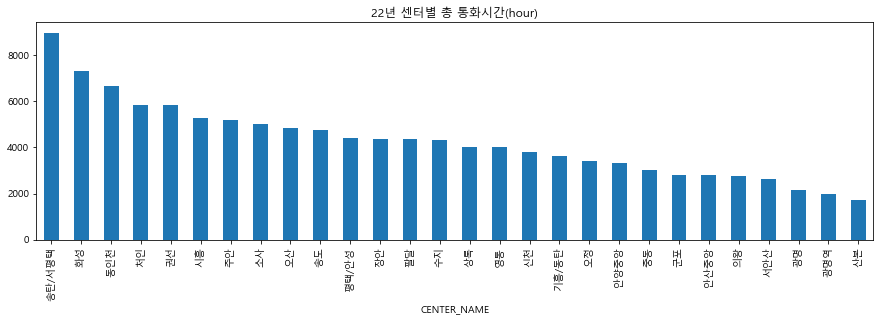

In [11]:
## 센터별 총 통화시간 구하기
a1 = df_2022.groupby('CENTER_NAME')['call_duration'].sum() 
## 통화시간(초) --> 시간으로 변환 
a2 = a1/3600
a3 = round(a2.sort_values(ascending = False), 1)

print(a3)
plt.figure(figsize=(15, 4))
plt.title('22년 센터별 총 통화시간(hour)')
a3.plot(kind='bar')

In [12]:
## 센터별 상담원수 구하기 
man_by_center = df_2022.groupby('CENTER_NAME')['EXTENSION'].nunique()
man_by_center.sort_values(ascending=False)

CENTER_NAME
송탄/서평택    15
화성        14
기흥/동탄     13
동인천       13
소사        12
권선        11
처인        11
주안        11
오산        11
평택/안성     10
송도        10
수지        10
시흥        10
안양중앙       9
중동         9
신천         9
안산중앙       9
영통         8
광명역        8
장안         8
상록         8
팔달         8
오정         7
산본         7
군포         7
의왕         6
서안산        6
광명         6
Name: EXTENSION, dtype: int64

In [13]:
## 두 데이터셋을 df 형태로 변경 
a4 = a3.to_frame()
a4.columns = ['tot_call_duration_hour']
a4.reset_index()

,CENTER_NAME,tot_call_duration_hour
0,송탄/서평택,8971.2
1,화성,7308.6
2,동인천,6644.8
3,처인,5852.8
4,권선,5832.6
5,시흥,5263.0
6,주안,5181.2
7,소사,5018.8
8,오산,4848.4
9,송도,4760.6


In [14]:
b4 = man_by_center.to_frame()
b4.columns = ['cnt_callers']
b4.reset_index()

,CENTER_NAME,cnt_callers
0,광명,6
1,광명역,8
2,군포,7
3,권선,11
4,기흥/동탄,13
5,동인천,13
6,산본,7
7,상록,8
8,서안산,6
9,소사,12


In [15]:
## 합치기 
c4 = a4.join(b4, how='inner', on='CENTER_NAME')
c4.reset_index()

,CENTER_NAME,tot_call_duration_hour,cnt_callers
0,송탄/서평택,8971.2,15
1,화성,7308.6,14
2,동인천,6644.8,13
3,처인,5852.8,11
4,권선,5832.6,11
5,시흥,5263.0,10
6,주안,5181.2,11
7,소사,5018.8,12
8,오산,4848.4,11
9,송도,4760.6,10


In [16]:
## 센터별 상담원 1인당 하루평균 통화시간 구하기 (연중 근무일수는 250일로 가정함)
c4['avg_per_caller_hour'] = (c4['tot_call_duration_hour'] / c4['cnt_callers'])/250
c5 = c4.reset_index().sort_values(by='avg_per_caller_hour', ascending=False)
c5

,CENTER_NAME,tot_call_duration_hour,cnt_callers,avg_per_caller_hour
0,송탄/서평택,8971.2,15,2.392320
11,장안,4387.7,8,2.193850
12,팔달,4356.4,8,2.178200
3,처인,5852.8,11,2.128291
4,권선,5832.6,11,2.120945
5,시흥,5263.0,10,2.105200
1,화성,7308.6,14,2.088171
2,동인천,6644.8,13,2.044554
14,상록,4035.3,8,2.017650
15,영통,4023.2,8,2.011600


<AxesSubplot:xlabel='CENTER_NAME', ylabel='avg_per_caller_hour'>

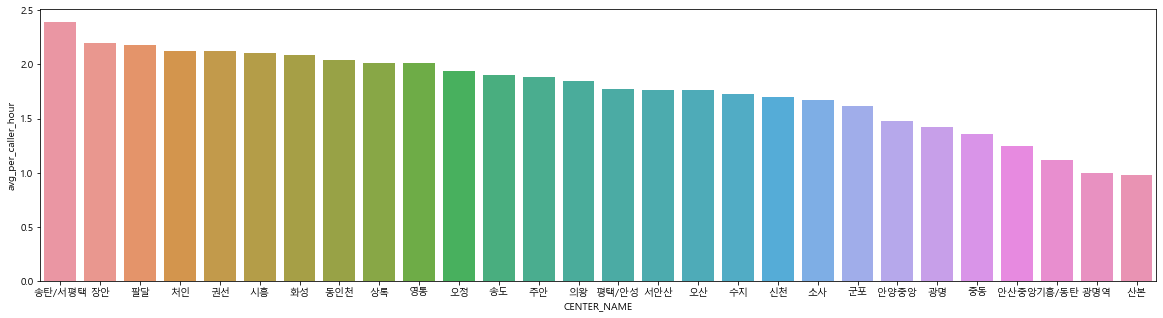

In [17]:
plt.figure(figsize = (20,5))
sns.barplot(data=c5, x='CENTER_NAME', y='avg_per_caller_hour')

In [18]:
df_2022.shape

(3345622, 64)

In [25]:
df_2022_3month = df_2022[df_2022['call_month'] == 1]
df_2022_3month.to_csv('data/df_2022_3month.csv', index=False)



In [19]:
df_2022.head()

,COUNSEL_CALL_HISTORY_EID,TEL,BOUND_TYPE_CODE,ARS_CHANNEL,START_TIME,END_TIME,CALL_TIME,PAYER_NUMBER,CUSTOMER_NAME,CUSTOMER_DIVISION_CLAS_CODE,DUTY_TYPE_CLAS_CODE,CENTER_NAME,CENTER_CODE,COUNSEL_NAME,CALL_RESULT_CODE,HOUSE_TYPE_CODE,USE_TYPE_CODE,CALL_ID,COUNSEL_MEMO,COUNSEL_TYPE_CODE,RELATIONSHIP_CODE,RELATIONSHIP_CENTER_CODE,ENTITY_STATUS,MOD_DATE,REG_DATE,MOD_USER_ENTITY_ID,REG_USER_ENTITY_ID,TRF_USER_ENTITY_ID,TRF_DATE,CALLBACK_TYPE_CODE,CALLBACK_FIT_CODE,DUTY_TYPE_CODE,CUSTOMER_DIVISION_CODE,BOUND_TYPE,CUSTOMER_DIVISION_CLAS,DUTY_TYPE_CLAS,HOUSE_TYPE,USE_TYPE,COUNSEL_TYPE,DUTY_TYPE,CUSTOMER_DIVISION,CALLBACK_TYPE,CALLBACK_FIT,CALL_RESULT,EXTENSION,END_CALL_TYPE,END_CALL_TYPE_CODE,REGION,REGION_CODE,GENDER,GENDER_CODE,BIRTH_DATE,PROCESS_CALLBACK_TYPE_CODE,PROCESS_CALLBACK_TYPE,URGENT_CODE,URGENT,VOC_ENTITY_ID,PARTNER,call_year,call_month,call_day,call_hour,call_weekday,call_duration
0,182612264.0,0326796155,IB,0상담원연결,2022-01-06 10:16:59,2022-01-06 10:17:55,56000.0,106824448,이영희,GENERAL,1,오정,16,None,SUCCESS,40,LOF1,548A5FA2-44DA-43C7-976B-F36D10B7CF8B,요금 내역서 발송,MODESTY,OWN,16,UPDATE,2022-01-06 10:18:11,2022-01-06 10:16:59,1721.0,1721.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,공동주택,업무용,겸손,요금문의,온화함,None,None,통화성공,6091,None,None,삼정동,None,여성,F,600315.0,None,None,None,None,96953091,700737322,2022,1,6,10,Thursday,56.0
1,182612760.0,03180199756,IB,0상담원연결,2022-01-06 10:17:29,2022-01-06 10:17:59,30000.0,304366212,김진영,GENERAL,1,동인천,11,None,SUCCESS,10,LRH1,9389BB5F-A391-4B53-9254-103F496A3B89,수납센터: 번호변경&요금문자요청,DOUCENESS,OWN,11,UPDATE,2022-01-06 10:18:41,2022-01-06 10:17:30,1677.0,1677.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,원룸,난방용,차분,요금문의,온화함,None,None,통화성공,6030,None,None,도화1동,None,남성,M,851024.0,None,None,None,None,96953118,707153261,2022,1,6,10,Thursday,30.0
2,182614699.0,0215447000,IB,0상담원연결,2022-01-06 10:19:25,2022-01-06 10:20:52,87000.0,106260994,박시원,GENERAL,1,군포,36,None,SUCCESS,None,LRH1,7BFAB79B-6948-480A-AD93-A7FA6FB8C60B,자동이체만 해지,LEAD,OWN,36,UPDATE,2022-01-06 10:21:06,2022-01-06 10:19:25,1812.0,1812.0,None,None,None,None,CHARGE,DESULTORY,인바운드,일반,문의,None,난방용,주도,요금문의,산만함,None,None,통화성공,6270,None,None,당동,None,여성,F,550819.0,None,None,None,None,96953199,702414760,2022,1,6,10,Thursday,87.0
3,182614889.0,01065978698,IB,0상담원연결,2022-01-06 10:19:35,2022-01-06 10:22:28,173000.0,304968846,박인준,GENERAL,1,송탄/서평택,48,None,SUCCESS,None,LRH1,E4C96B95-3CCD-4A15-AE81-50A65F875086,명의변경/검침문의,DOUCENESS,OWN,48,UPDATE,2022-01-06 10:22:33,2022-01-06 10:19:35,1921.0,1921.0,None,None,None,None,CUST-INFO,SERIOUSNESS,인바운드,일반,문의,None,난방용,차분,고객정보문의,진지함,None,None,통화성공,6441,None,None,서정동,None,남성,M,681204.0,None,None,None,None,96953534,707756958,2022,1,6,10,Thursday,173.0
4,182620523.0,0215447000,IB,0상담원연결,2022-01-06 10:24:34,2022-01-06 10:26:29,115000.0,110789193,임미자,GENERAL,1,화성,43,None,SUCCESS,61,LRC1,F0BEBEBC-1B44-418E-BBB5-B8FB7F837837,자동이체 해지,LEAD,OWN,43,UPDATE,2022-01-06 10:26:38,2022-01-06 10:24:34,1865.0,1865.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,아파트_계단식,취사용,주도,요금문의,온화함,None,None,통화성공,6364,None,None,반월동,None,여성,F,610510.0,None,None,None,None,96953678,700056074,2022,1,6,10,Thursday,115.0
